In [1]:
import torch
import torch.utils.data
import torch.nn
import torchvision
import torchvision.datasets
import torchvision.transforms
import torchvision.models
import os
import time

from matplotlib import pyplot as plt

### Объявление констант

In [2]:
BATCH_SIZE = 100
LEARNING_RATE = 0.001
NUM_EPOCHS = 5
NUM_CLASSES = 10
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DIR_NAME = os.getcwd()
LOSS = torch.nn.CrossEntropyLoss()

DEVICE

device(type='cuda', index=0)

### Создадим класс для моделей из библиотеки torchvisions:

In [3]:
class PretrainedModel:
  def __init__(self, name, weights, in_features, is_deep=False, loss=LOSS):
    self.name = name
    self.weights = weights
    self.in_features = in_features
    self.is_deep = is_deep
    self.loss = loss

    self.transform = torchvision.models.get_weight(weights).transforms()
    self.model = torchvision.models.get_model(name, weights=weights)
    self.model.to(DEVICE)

    self.train_dataset = torchvision.datasets.CIFAR10(
        root=DIR_NAME, train=True,
        download=True, transform=self.transform
    )
    self.train_data_loader = torch.utils.data.DataLoader(
        self.train_dataset, batch_size=BATCH_SIZE, shuffle=True
    )

    self.test_dataset = torchvision.datasets.CIFAR10(
        root=DIR_NAME, train=False,
        download=True, transform=self.transform
    )
    self.test_data_loader = torch.utils.data.DataLoader(
        self.test_dataset, batch_size=BATCH_SIZE, shuffle=False
    )

    self.criterion = torch.nn.CrossEntropyLoss(reduction='mean')
    self.optimizer = {}

    self.prepare_for_traininig()

    print(self.model)


  def replace_classifier(self):
    classifier = {}

    if not self.is_deep:
      classifier = torch.nn.Linear(self.in_features, NUM_CLASSES).to(DEVICE)
    else:
      hidden_size = self.in_features // 2
      classifier = torch.nn.Sequential(
          torch.nn.Linear(self.in_features, hidden_size),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_size, NUM_CLASSES)
      ).to(DEVICE)

    if hasattr(self.model, "classifier"):
      self.model.classifier = classifier
      self.optimizer = torch.optim.Adam(
          getattr(self.model, "classifier").parameters(),
          lr=LEARNING_RATE
      )
    elif hasattr(self.model, "fc"):
      self.model.fc = classifier
      self.optimizer = torch.optim.Adam(
          getattr(self.model, "fc").parameters(),
          lr=LEARNING_RATE
      )
    else:
      print("no classifier")


  def prepare_for_traininig(self):
    for param in self.model.parameters():
      param.requires_grad = False

    self.replace_classifier()


  def train_epoch(self):
    self.model.train()
    correct = 0
    total = 0

    for images, labels in self.train_data_loader:
      self.optimizer.zero_grad()

      images = images.type(torch.float32)
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      predicted = self.model(images)
      loss = self.loss(
          predicted.type(torch.float32),
          torch.nn.functional.one_hot(labels, num_classes=NUM_CLASSES).type(torch.float32),
      )

      corrects = labels == predicted.argmax(dim=1)
      correct += int(corrects.sum())

      loss.backward()
      self.optimizer.step()
      total += len(predicted)

    return correct / total

  def train(self):
    num_epochs = NUM_EPOCHS + 1 if self.is_deep else NUM_EPOCHS - 1
    for epoch in range(num_epochs):
      start_time = time.time()
      train_accuracy = self.train_epoch()
      time_of_train = time.time() - start_time

      print('Epoch[{}]: Train accuracy = {:.3f}, Time = {:.3f}s'
            .format(epoch + 1, train_accuracy, time_of_train))
      yield self.model


  def test(self):
    self.model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
      for images, labels in self.test_data_loader:
        self.optimizer.zero_grad()
        images = images.type(torch.float32)

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        predicted = self.model(images)

        corrects = labels == predicted.argmax(dim=1)
        correct += int(corrects.sum())
        total += len(predicted)

    print('Test accuracy = {:.3f}'.format(correct / total))


def train_model(model):
  for progress in model.train():
    print()

def test_model(model):
  model.test()

### 1. ResNet18

In [ ]:
resnet18 = PretrainedModel('resnet18', 'ResNet18_Weights.DEFAULT', 512)

Files already downloaded and verified
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [ ]:
train_model(resnet18)

Epoch[1]: Train accuracy = 0.687, Time = 192.265s

Epoch[2]: Train accuracy = 0.760, Time = 198.100s

Epoch[3]: Train accuracy = 0.772, Time = 197.690s

Epoch[4]: Train accuracy = 0.778, Time = 206.171s



In [ ]:
test_model(resnet18)

Test accuracy = 0.774


In [5]:
resnet18_deep = PretrainedModel('resnet18', 'ResNet18_Weights.DEFAULT', 512, True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


100%|██████████| 170498071/170498071 [00:12<00:00, 13132230.40it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e

In [6]:
train_model(resnet18_deep)

Epoch[1]: Train accuracy = 0.721, Time = 181.374s

Epoch[2]: Train accuracy = 0.764, Time = 175.077s

Epoch[3]: Train accuracy = 0.776, Time = 180.623s

Epoch[4]: Train accuracy = 0.785, Time = 180.756s

Epoch[5]: Train accuracy = 0.792, Time = 176.585s

Epoch[6]: Train accuracy = 0.802, Time = 173.777s



In [7]:
test_model(resnet18_deep)

Test accuracy = 0.791


### 2. RegNetX_400MF (weights V2)

In [9]:
regnetx_400mf = PretrainedModel('regnet_x_400mf', 'RegNet_X_400MF_Weights.IMAGENET1K_V2', 400)

Downloading: "https://download.pytorch.org/models/regnet_x_400mf-62229a5f.pth" to /root/.cache/torch/hub/checkpoints/regnet_x_400mf-62229a5f.pth
100%|██████████| 21.3M/21.3M [00:02<00:00, 8.13MB/s]


Files already downloaded and verified
Files already downloaded and verified
RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_si

In [10]:
train_model(regnetx_400mf)

Epoch[1]: Train accuracy = 0.668, Time = 264.184s

Epoch[2]: Train accuracy = 0.754, Time = 265.164s

Epoch[3]: Train accuracy = 0.767, Time = 265.457s

Epoch[4]: Train accuracy = 0.776, Time = 263.294s



In [11]:
test_model(regnetx_400mf)

Test accuracy = 0.777


In [12]:
regnetx_400mf_deep = PretrainedModel('regnet_x_400mf', 'RegNet_X_400MF_Weights.IMAGENET1K_V2', 400, True)

Files already downloaded and verified
Files already downloaded and verified
RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_si

In [13]:
train_model(regnetx_400mf_deep)

Epoch[1]: Train accuracy = 0.719, Time = 267.711s

Epoch[2]: Train accuracy = 0.768, Time = 267.249s

Epoch[3]: Train accuracy = 0.781, Time = 265.963s

Epoch[4]: Train accuracy = 0.786, Time = 264.365s

Epoch[5]: Train accuracy = 0.790, Time = 264.072s

Epoch[6]: Train accuracy = 0.793, Time = 264.544s



In [14]:
test_model(regnetx_400mf_deep)

Test accuracy = 0.778


### 3. GoogleNet

In [21]:
googlenet = PretrainedModel('googlenet', 'GoogLeNet_Weights.DEFAULT', 1024)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 86.2MB/s]


Files already downloaded and verified
Files already downloaded and verified
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=Fa

In [22]:
train_model(googlenet)

Epoch[1]: Train accuracy = 0.690, Time = 191.181s

Epoch[2]: Train accuracy = 0.747, Time = 187.182s

Epoch[3]: Train accuracy = 0.756, Time = 185.651s

Epoch[4]: Train accuracy = 0.764, Time = 184.888s



In [23]:
test_model(googlenet)

Test accuracy = 0.777


In [24]:
googlenet_deep = PretrainedModel('googlenet', 'GoogLeNet_Weights.DEFAULT', 1024, True)

Files already downloaded and verified
Files already downloaded and verified
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=Fa

In [25]:
train_model(googlenet_deep)

Epoch[1]: Train accuracy = 0.704, Time = 188.589s

Epoch[2]: Train accuracy = 0.750, Time = 185.588s

Epoch[3]: Train accuracy = 0.757, Time = 186.028s

Epoch[4]: Train accuracy = 0.766, Time = 185.657s

Epoch[5]: Train accuracy = 0.773, Time = 186.469s

Epoch[6]: Train accuracy = 0.780, Time = 186.683s



In [26]:
test_model(googlenet_deep)

Test accuracy = 0.800


### 4. MnasNet 0.5

In [27]:
mnasnet0_5 = PretrainedModel('mnasnet0_5', 'MNASNet0_5_Weights.DEFAULT', 1280)

Downloading: "https://download.pytorch.org/models/mnasnet0.5_top1_67.823-3ffadce67e.pth" to /root/.cache/torch/hub/checkpoints/mnasnet0.5_top1_67.823-3ffadce67e.pth
100%|██████████| 8.59M/8.59M [00:00<00:00, 113MB/s]


Files already downloaded and verified
Files already downloaded and verified
MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(8, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running

In [29]:
train_model(mnasnet0_5)

Epoch[1]: Train accuracy = 0.695, Time = 176.541s

Epoch[2]: Train accuracy = 0.729, Time = 167.454s

Epoch[3]: Train accuracy = 0.746, Time = 165.009s

Epoch[4]: Train accuracy = 0.756, Time = 165.967s



In [31]:
test_model(mnasnet0_5)

Test accuracy = 0.318


In [32]:
mnasnet0_5_deep = PretrainedModel('mnasnet0_5', 'MNASNet0_5_Weights.DEFAULT', 1280, True)

Files already downloaded and verified
Files already downloaded and verified
MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(8, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running

In [33]:
train_model(mnasnet0_5_deep)

Epoch[1]: Train accuracy = 0.719, Time = 163.919s

Epoch[2]: Train accuracy = 0.778, Time = 165.553s

Epoch[3]: Train accuracy = 0.796, Time = 164.530s

Epoch[4]: Train accuracy = 0.808, Time = 165.309s

Epoch[5]: Train accuracy = 0.816, Time = 164.520s

Epoch[6]: Train accuracy = 0.829, Time = 165.437s



In [34]:
test_model(mnasnet0_5_deep)

Test accuracy = 0.285


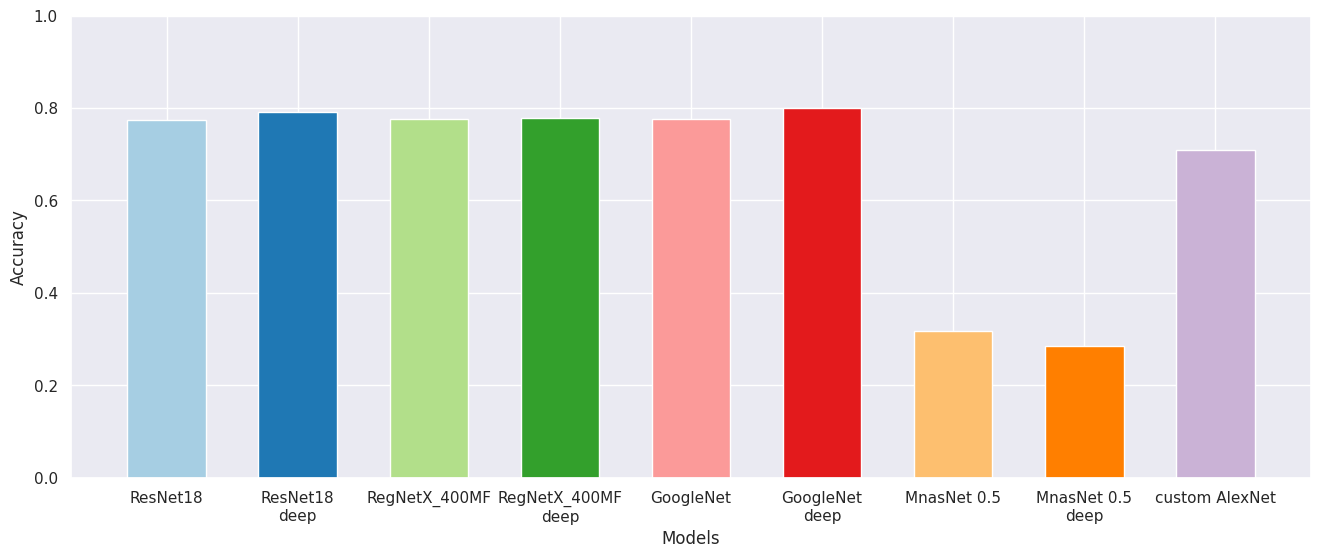

In [48]:
from matplotlib import colormaps

data = {
    'ResNet18': 0.774,
    'ResNet18\ndeep': 0.791,

    'RegNetX_400MF': 0.777,
    'RegNetX_400MF\ndeep': 0.778,

    'GoogleNet': 0.777,
    'GoogleNet\ndeep': 0.8,

    'MnasNet 0.5': 0.318,
    'MnasNet 0.5\ndeep': 0.285,

    'custom AlexNet': 0.71,
}

models = list(data.keys())
values = list(data.values())

col_map = plt.get_cmap('Paired')
color = ['coral', 'blue', 'purple', 'red', 'black']
plt.ylim([0.0, 1.0])
plt.bar(models, values, width=0.6, color=col_map.colors)

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()

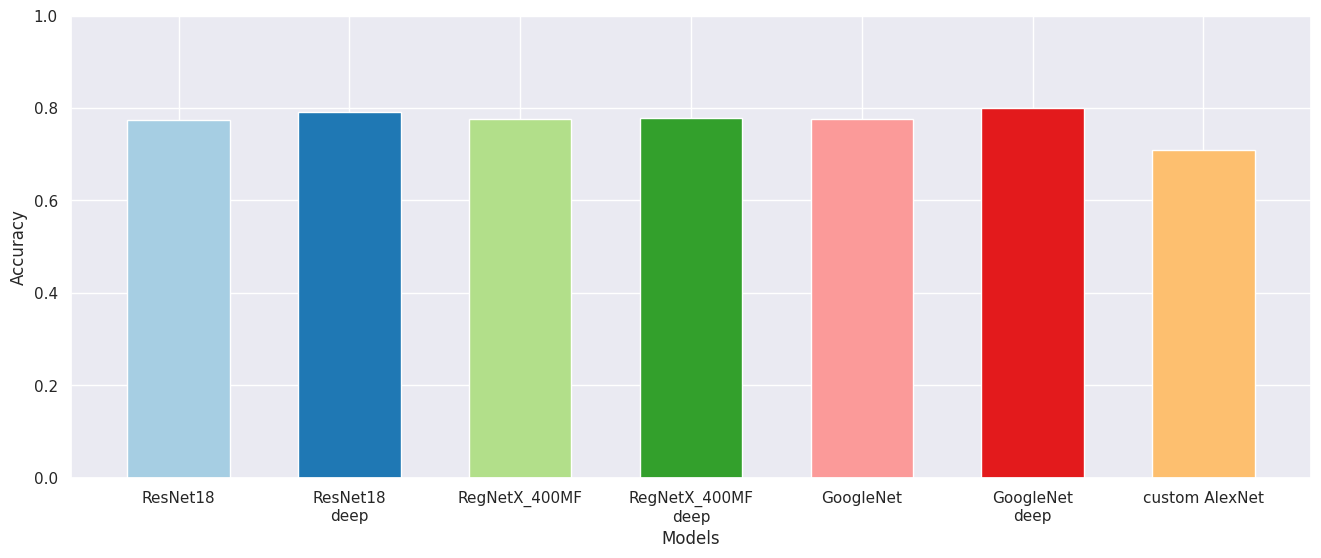

In [49]:
from matplotlib import colormaps

data = {
    'ResNet18': 0.774,
    'ResNet18\ndeep': 0.791,

    'RegNetX_400MF': 0.777,
    'RegNetX_400MF\ndeep': 0.778,

    'GoogleNet': 0.777,
    'GoogleNet\ndeep': 0.8,

    'custom AlexNet': 0.71,
}

models = list(data.keys())
values = list(data.values())

col_map = plt.get_cmap('Paired')
color = ['coral', 'blue', 'purple', 'red', 'black']
plt.ylim([0.0, 1.0])
plt.bar(models, values, width=0.6, color=col_map.colors)

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()